In [1]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [2]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://www.genspark.ai/spark/langgraph%E3%81%AE%E3%83%8E%E3%83%BC%E3%83%89%E3%81%AE%E5%87%BA%E5%8A%9B%E5%9E%8B%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6/950c187d-6dd0-4ca5-8d6d-35da0d5cbf85',
  'content': 'Ask anything\n\nTable of Contents\n\nインスピレーションと洞察から生成されました 7 ソースから\n\n## はじめに\n\n LangGraphのノードは、エージェントの状態を受け取り、更新した状態を返す関数として定義されます。\n ノードの出力は、通常、状態の一部を更新した辞書形式で返されます。\n ToolNodeは、AIMessageのtool\\_callsを実行し、その結果をToolMessageのリストとして返します。\n ノードの出力型は、状態の更新方法に依存し、TypedDictやPydantic BaseModelで定義されることが多いです。\n LangGraphでは、ノードの出力をどのように更新するかを定義するためにreducersが使用されます。\n\n## LangGraphの基本要素+%E5%9F%BA%E6%9C%AC%E8%A6%81%E7%B4%A0) [...] Graph: エージェントのワークフローをモデル化したもの。\n State: エージェントの状態を定義し、ノード間で受け渡されるデータ。\n Node: 各処理を行う関数で、状態を受け取り更新する。\n Edge: ノード間のつながりを定義し、処理の順序を決定する。\n Reducers: 状態の各要素をどのように更新するかを定義する。\n\n## ToolNodeの詳細+%E8%A9%B3%E7%B4%B0) \n\n ToolNodeは、AIMessageのtool\\_callsを実行するノード。\n 複数のtool\\_callsがある場合、並行して実行される。\n 出力は、各tool\\_callに対応するToolMessageのリスト。\n ToolNodeは、StateGraphまたはMessageGra

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [5]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

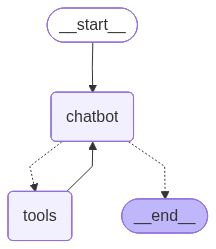

In [6]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！今日はどのようなお手伝いをしましょうか？
1足す2は？
1足す2は3です。何か他に知りたいことがありますか？
1メートル以上の魚は？

[{"url": "https://tsurihack.com/8448", "content": "どの魚も、陸っぱりで狙えて最大全長が1mを超えるものばかり！\n\nお住まいの地域にこれからリストアップする魚が生息していたら、狙ってみてはいかがでしょうか。\n\n鯉｜もっとも手軽で簡単な大物\n\n難易度：★☆☆｜平均70cm、1m超えれば超絶レア\n魚釣り初心者の方にオススメしたいのは食パンを使ったコイ釣りです！\n\n安・近・短で手軽に釣ることができ、ボウズ（釣果ゼロ）で終わってしまうリスクも少ないのがパンコイゲームの魅力ですね。\n\n▼食パンを使ったコイの釣り方はこちら！\n針と餌だけのカンタン仕掛けで巨大魚が釣れる！？“パン鯉”に子供と挑戦してみました2023/04/27釣り好き！まっちゃん\n\n針と餌だけのカンタン仕掛けで巨大魚が釣れる！？“パン鯉”に子供と挑戦してみました\n\n2023/04/27釣り好き！まっちゃん\n\n1mを超えるコイは超絶レアですよ！\n\n身近な川魚のコイといえども最大サイズは1ｍを優に超え、コイを専門に狙う釣り人にとってメーター超えの巨鯉は一生に1匹でも良いから釣ってみたい憧れのサイズです。 [...] 最大で1mに迫るような大物を釣り狙う場合、例え身近な魚であっても釣り具の強度や仕掛け、ルアーの種類などをしっかり選ぶ必要があります。\n\n『この魚を釣ってみたい！』という確固たる目標を持って挑戦していく過程が大物釣り最大の醍醐味であり、準備や試行錯誤の期間が長い程、目標を手にした瞬間、つまり大物を釣り上げた瞬間の感動と達成感はなんとも言葉に表すことができないものになってきます。\n\n全身が震えたり、感情を抑えられず雄たけびやガッツポーズが出ちゃったりする……そんな体験を大人になっても味わえる。それが魚釣りの良い所だと僕は思っています。\n\n大物を釣り上げるまでの3ステップをお伝えします\n\nどんな大物を釣りたいか決めましょう\n\nまずは、自分の目標とする魚を設定しましょう。魚種でも良いですし、この魚の何センチ以上！　とかでも素敵な目標だと思います。